In [1]:
# Import necessary libraries

import zipfile
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten, add
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !unzip '/content/drive/MyDrive/ulcer/ulcer_diabetes.zip'

## **Step 1: Data Understanding**

In [4]:
# Load Dataset and understand its structure
file_path_csv = '/content/Patches/diabetes_ulcer_final_varied_dataset.csv'

dataset = pd.read_csv(file_path_csv)
dataset.head()

,image,level,infection,recommendation,caption
0,abnormal (1).jpg,Abnormal,Yes,Konsultasi segera untuk mencegah komplikasi le...,Ulkus diabetik mengalami infeksi yang memerluk...
1,abnormal (10).jpg,Abnormal,Yes,Konsultasikan dengan dokter untuk kemungkinan ...,Infeksi pada ulkus diabetik terindikasi cukup ...
2,abnormal (100).jpg,Abnormal,Yes,Disarankan untuk mengunjungi fasilitas kesehatan.,Luka dengan tingkat keparahan tinggi dan infek...
3,abnormal (101).jpg,Abnormal,Yes,Segera konsultasikan dengan dokter untuk evalu...,Kondisi luka dan infeksi memerlukan penanganan...
4,abnormal (102).jpg,Abnormal,Yes,Segera konsultasikan dengan dokter untuk evalu...,Infeksi pada ulkus diabetik terindikasi cukup ...


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image           1055 non-null   object
 1   level           899 non-null    object
 2   infection       899 non-null    object
 3   recommendation  899 non-null    object
 4   caption         899 non-null    object
dtypes: object(5)
memory usage: 41.3+ KB


# **Step 2: Data Preparation**

In [6]:
# Extract relevant columns
dataset['image_path'] = dataset['image'].apply(lambda x: os.path.join('/content/Patches/images', x.split(',')[0].strip()))

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Tokenize captions
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['caption'].astype(str).fillna(''))
train_sequences = tokenizer.texts_to_sequences(train_data['caption'].astype(str).fillna(''))
train_padded = pad_sequences(train_sequences, padding='post')

val_sequences = tokenizer.texts_to_sequences(val_data['caption'].astype(str).fillna(''))
val_padded = pad_sequences(val_sequences, padding='post')

# Encode captions with LabelEncoder to ensure all values are numeric and within bounds
caption_encoder = LabelEncoder()
train_data['caption_encoded'] = caption_encoder.fit_transform(train_data['caption'].astype(str))
val_data['caption_encoded'] = caption_encoder.transform(val_data['caption'].astype(str))



## **Step 3: Train and Fine-tune VGG16 for Classification**

In [7]:
# Load VGG16 pre-trained model without the top layer (include_top=False)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some VGG16 layers for fine-tuning
for layer in vgg_model.layers:
    layer.trainable = True  # Unfreeze all layers for fine-tuning

# Add custom layers for classification
x = vgg_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Assuming 3 classes for level classification

# Compile the model
vgg_classification_model = Model(inputs=vgg_model.input, outputs=output)
vgg_classification_model.summary()

vgg_classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 21,138,243 (80.64 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Prepare image data for training the VGG16 model
train_images = np.array([img_to_array(load_img(img_path, target_size=(224, 224))) for img_path in train_data['image_path']])
train_images = tf.keras.applications.vgg16.preprocess_input(train_images)
val_images = np.array([img_to_array(load_img(img_path, target_size=(224, 224))) for img_path in val_data['image_path']])
val_images = tf.keras.applications.vgg16.preprocess_input(val_images)

In [9]:
# Label encode the categorical column 'level'
encoder = LabelEncoder()
train_data['level'] = encoder.fit_transform(train_data['level'].astype(str))
val_data['level'] = encoder.transform(val_data['level'].astype(str))

train_labels = tf.keras.utils.to_categorical(train_data['level'], num_classes=len(encoder.classes_))
val_labels = tf.keras.utils.to_categorical(val_data['level'], num_classes=len(encoder.classes_))


In [10]:
# Train the VGG16 model
vgg_classification_model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=32)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.5203 - loss: 4.3859 - val_accuracy: 0.8152 - val_loss: 0.8286
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 547ms/step - accuracy: 0.6953 - loss: 1.0321 - val_accuracy: 0.8104 - val_loss: 0.7088
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 528ms/step - accuracy: 0.7768 - loss: 0.6654 - val_accuracy: 0.8104 - val_loss: 0.6557
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.7943 - loss: 0.5532 - val_accuracy: 0.8199 - val_loss: 0.6865
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - accuracy: 0.8081 - loss: 0.4546 - val_accuracy: 0.8294 - val_loss: 0.6733
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 555ms/step - accuracy: 0.8618 - loss: 0.3402 - val_accuracy: 0.8246 - val_loss: 0.6972
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 550ms/step - accuracy: 0.8769 - loss: 0.3130 - val_accuracy: 0.8152 - val_loss: 0.7020
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 548ms/step - accuracy: 0.8862 - loss: 0.2575 - val_accura

In [11]:
# Evaluate the VGG16 model
evaluation_vgg = vgg_classification_model.evaluate(val_images, val_labels)
print(f"VGG16 Evaluation Loss: {evaluation_vgg[0]}")
print(f"VGG16 Evaluation Accuracy: {evaluation_vgg[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8060 - loss: 0.8486
VGG16 Evaluation Loss: 0.681494414806366
VGG16 Evaluation Accuracy: 0.8246445655822754


## **Step 4: Extract Features Using Trained VGG16 Model**

In [12]:

# Extract features for the entire dataset
train_image_features = vgg_classification_model.predict(train_images)
val_image_features = vgg_classification_model.predict(val_images)

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 418ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


In [13]:
train_sequences = tokenizer.texts_to_sequences(train_data['caption'].astype(str).fillna(''))
train_padded = pad_sequences(train_sequences, padding='post')
val_sequences = tokenizer.texts_to_sequences(val_data['caption'].astype(str).fillna(''))
val_padded = pad_sequences(val_sequences, padding='post')

## **Step 5: Train LSTM Model for Caption Generation**

In [14]:
# Sequential model to process extracted image features followed by LSTM for captions
lstm_model = Sequential()
lstm_model.add(Input(shape=(train_padded.shape[1],)))  # Input for caption sequence
lstm_model.add(Embedding(input_dim=5000, output_dim=256, mask_zero=True))
lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(256))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(256, activation='relu'))
lstm_model.add(Dense(len(caption_encoder.classes_), activation='softmax'))  # 4 outputs for level, infection, recommendation, and caption

# Compile the LSTM model
lstm_model.summary()

lstm_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 16, 256)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 19)                  │           4,883 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,401,299 (9.16 MB)

 Trainable params: 2,401,299 (9.16 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the LSTM model using image features and caption sequences
lstm_model.fit(
    [train_image_features, train_padded],
    tf.keras.utils.to_categorical(train_data['caption_encoded'].values, num_classes=len(caption_encoder.classes_)),
    validation_data=([val_image_features, val_padded], tf.keras.utils.to_categorical(val_data['caption_encoded'].values, num_classes=len(caption_encoder.classes_))),
    epochs=10,
    batch_size=32
)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0478 - loss: 2.9440 - val_accuracy: 0.1280 - val_loss: 2.9440
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0762 - loss: 2.9435 - val_accuracy: 0.1280 - val_loss: 2.9438
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1301 - loss: 2.9433 - val_accuracy: 0.1280 - val_loss: 2.9435
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1452 - loss: 2.9423 - val_accuracy: 0.1280 - val_loss: 2.9432
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1277 - loss: 2.9427 - val_accuracy: 0.1280 - val_loss: 2.9430
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1668 - loss: 2.9416 - val_accuracy: 0.1280 - val_loss: 2.9427
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1795 - loss: 2.9409 - val_accuracy: 0.1280 - val_loss: 2.9423
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1291 - loss: 2.9414 - val_accuracy: 0.1280 - val

In [16]:
evaluation_lstm = lstm_model.evaluate(
    [val_image_features, val_padded],
    tf.keras.utils.to_categorical(val_data['caption_encoded'].values, num_classes=len(caption_encoder.classes_))
)
print(f"LSTM Evaluation Loss: {evaluation_lstm[0]}")
print(f"LSTM Evaluation Accuracy: {evaluation_lstm[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1366 - loss: 2.9414 
LSTM Evaluation Loss: 2.9411675930023193
LSTM Evaluation Accuracy: 0.12796208262443542


## **Step 6: Combine VGG16 and LSTM Models**

In [17]:
# Define inputs for the combined model
# Define inputs for the combined model
image_input = Input(shape=(224, 224, 3))
caption_input = Input(shape=(train_padded.shape[1],))

# Use VGG16 for feature extraction from images
vgg_features = vgg_classification_model(image_input)

# Embedding and LSTM for text data
embedding_layer = Embedding(input_dim=5000, output_dim=256, mask_zero=True)(caption_input)
lstm_out = LSTM(256, return_sequences=True)(embedding_layer)
lstm_out = Dropout(0.5)(lstm_out)
lstm_out = LSTM(256)(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)

# Combine image features and LSTM output
from tensorflow.keras.layers import Concatenate

vgg_features_flat = Flatten()(vgg_features)
combined = Concatenate()([vgg_features_flat, lstm_out])
x = Dense(256, activation='relu')(combined)
output = Dense(len(caption_encoder.classes_), activation='softmax')(x)  # 4 outputs for level, infection, recommendation, and caption

# Full combined model
combined_model = Model(inputs=[image_input, caption_input], outputs=output)

# Compile the combined model
combined_model.summary()

combined_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 16)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 16, 256)        │      1,280,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_7 (NotEqual)    │ (None, 16)             │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 16, 256)        │        525,312 │ embedding_1[0][0],     │
│                           │                        │                │ not_equal_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 256)        │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 3)              │     21,138,243 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 256)            │        525,312 │ dropout_3[0][0],       │
│                           │                        │                │ not_equal_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 3)              │              0 │ functional[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 259)            │              0 │ flatten_1[0][0],       │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         66,560 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 19)             │          4,883 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,540,310 (89.80 MB)

 Trainable params: 23,540,310 (89.80 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the combined model
combined_model.fit(
    [train_images, train_padded],
    tf.keras.utils.to_categorical(train_data['caption_encoded'].values, num_classes=len(caption_encoder.classes_)),
    validation_data=([val_images, val_padded], tf.keras.utils.to_categorical(val_data['caption_encoded'].values, num_classes=len(caption_encoder.classes_))),
    epochs=10,
    batch_size=32
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 889ms/step - accuracy: 0.0679 - loss: 0.0000e+00 - val_accuracy: 0.0995 - val_loss: 0.0000e+00
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 525ms/step - accuracy: 0.0669 - loss: 0.0000e+00 - val_accuracy: 0.1232 - val_loss: 0.0000e+00
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.0926 - loss: 0.0000e+00 - val_accuracy: 0.1517 - val_loss: 0.0000e+00
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 509ms/step - accuracy: 0.1059 - loss: 0.0000e+00 - val_accuracy: 0.1469 - val_loss: 0.0000e+00
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 523ms/step - accuracy: 0.1092 - loss: 0.0000e+00 - val_accuracy: 0.1374 - val_loss: 0.0000e+00
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 511ms/step - accuracy: 0.1267 - loss: 0.0000e+00 - val_accuracy: 0.1517 - val_loss: 0.0000e+00
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 525ms/step - accuracy: 0.1462 - loss: 0.0000e+00 - val_accuracy: 0.1896 - val_loss: 0.0000e+00
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s

In [19]:
# Evaluate the combined model
evaluation_combined = combined_model.evaluate(
    [val_images, val_padded],
    tf.keras.utils.to_categorical(val_data['caption_encoded'].values, num_classes=len(caption_encoder.classes_))
)
print(f"Combined Model Evaluation Loss: {evaluation_combined[0]}")
print(f"Combined Model Evaluation Accuracy: {evaluation_combined[1]}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.2851 - loss: 0.0000e+00
Combined Model Evaluation Loss: 0.0
Combined Model Evaluation Accuracy: 0.0


## **Step 7: Save the Models**

In [20]:
# # Save the VGG16 classification model
# vgg_classification_model.save('vgg16_classification_model.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(vgg_classification_model)
# vgg16_tflite_model = converter.convert()
# with open('vgg16_classification_model.tflite', 'wb') as f:
#     f.write(vgg16_tflite_model)

In [21]:
# # Save the LSTM model
# lstm_model.save('lstm_captioning_model.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
# lstm_tflite_model = converter.convert()
# with open('lstm_captioning_model.tflite', 'wb') as f:
#     f.write(lstm_tflite_model)

In [22]:

# # Save the combined model
# combined_model.save('combined_model_savedmodel')
# converter = tf.lite.TFLiteConverter.from_keras_model(combined_model)
# combined_tflite_model = converter.convert()
# with open('combined_model.tflite', 'wb') as f:
#     f.write(combined_tflite_model)

## **Step 8: Load and Preprocess Image for Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


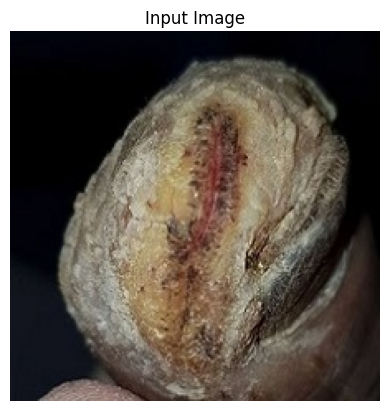

Predicted class: Infeksi aktif dan kondisi abnormal memerlukan intervensi medis segera.
Raw Predicted values: [0.05897579 0.04770703 0.05477752 0.0503299  0.04504888 0.05633606
 0.05097689 0.04984574 0.05312016 0.05830164 0.05100014 0.05582073
 0.05508507 0.0577416  0.04882848 0.05149963 0.05433691 0.04600017
 0.0542677 ]


In [25]:
image_path = '/content/Patches/images/abnormal (1).jpg'  # Replace with the actual image path
processed_image = load_img(image_path, target_size=(224, 224))
processed_image = img_to_array(processed_image)
processed_image = tf.keras.applications.vgg16.preprocess_input(processed_image)

# Dummy caption input for prediction (using padding)
dummy_caption = pad_sequences([[1, 2, 3]], maxlen=train_padded.shape[1], padding='post')

# Generate Prediction using the Combined Model
prediction = combined_model.predict([np.expand_dims(processed_image, axis=0), dummy_caption])

# Display the Image
import matplotlib.pyplot as plt
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
plt.imshow(img_array)
plt.axis('off')
plt.title('Input Image')
plt.show()

# Print the Results
predicted_class_index = np.argmax(prediction[0])
class_name = caption_encoder.inverse_transform([predicted_class_index])[0]
print(f"Predicted class: {class_name}")
print(f"Raw Predicted values: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


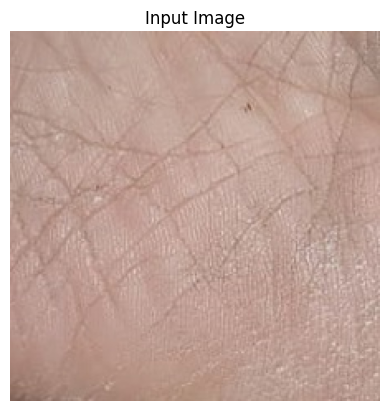

Predicted class: Tidak ada indikasi abnormalitas. Pertahankan kebersihan luka dan lakukan pengamatan rutin.
Raw Predicted values: [0.05683173 0.04645582 0.05315227 0.05405109 0.05177901 0.05389257
 0.05449116 0.05507718 0.04543598 0.05463937 0.04892837 0.05738708
 0.04829089 0.05597529 0.05093056 0.05519816 0.04903449 0.05176985
 0.05667913]


In [27]:
image_path = '/content/Patches/images/normal (438).jpg'  # Replace with the actual image path
processed_image = load_img(image_path, target_size=(224, 224))
processed_image = img_to_array(processed_image)
processed_image = tf.keras.applications.vgg16.preprocess_input(processed_image)

# Dummy caption input for prediction (using padding)
dummy_caption = pad_sequences([[1, 2, 3]], maxlen=train_padded.shape[1], padding='post')

# Generate Prediction using the Combined Model
prediction = combined_model.predict([np.expand_dims(processed_image, axis=0), dummy_caption])

# Display the Image
import matplotlib.pyplot as plt
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
plt.imshow(img_array)
plt.axis('off')
plt.title('Input Image')
plt.show()

# Print the Results
predicted_class_index = np.argmax(prediction[0])
class_name = caption_encoder.inverse_transform([predicted_class_index])[0]
print(f"Predicted class: {class_name}")
print(f"Raw Predicted values: {prediction[0]}")